AI Programming - SW Lee

# Lab 03: Optimizers for Deep Neural Networks
## Exercise: Predicting MNIST Digits
### For this exercise, prepare privious Lab to copy your previous implementations.

### Prepare Mini-MNIST Dataset

In [1]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [2]:
digits = load_digits()

# digits.data from sklearn contains 1797 images of 8x8 pixels
# Each image has a hand-written digit
digits_df = digits.images.reshape((len(digits.target), -1))
digits_tf = digits.target

# Splitting dataframe into train & test
X_train_org, X_test_org, y_train_num, y_test = train_test_split(digits_df, digits_tf, test_size= 0.20, random_state= 101)

# Digits data has range of [0,16], which often lead too big exponential values
# so make them normal distribution of [0,1] with the sklearn package, or you can just divide them by 16
sc = StandardScaler()
X_train = sc.fit_transform(X_train_org)
X_test = sc.transform(X_test_org)

n_classes = 10

# Transform Nx1 Y vector into Nx10 answer vector, so that we can perform one-to-all classification
y_train = np.zeros((y_train_num.shape[0],10))
for i in range(n_classes):
    y_train[:,i] = (y_train_num == i)

Define Utility Functions

In [3]:
from tensorflow.math import sigmoid as tf_sigmoid
from tensorflow.nn import softmax as tf_softmax

def sigmoid(x):
    x = tf_sigmoid(x)
    return x.numpy()

def softmax(x):
    x = tf_softmax(x)
    return x.numpy()

(1797, 64)
(1437, 64)
(1437, 10)
[ 0.  0.  0.  9. 16.  6.  0.  0.  0.  0.  4. 15.  6. 15.  0.  0.  0.  0.
  8. 11.  9. 11.  0.  0.  0.  0.  8. 16. 14.  2.  0.  0.  0.  0. 11. 16.
 13.  0.  0.  0.  0.  6. 14.  2. 12.  9.  0.  0.  0.  5. 16. 11.  5. 13.
  4.  0.  0.  0.  3.  8. 13. 16.  9.  0.]


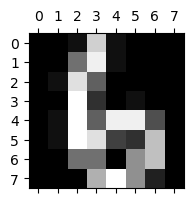

The number is 6


In [4]:
print(digits_df.shape)
print(X_train.shape)
print(y_train.shape)
print(X_train_org[0])

idx = np.random.randint(X_train.shape[0])
dimage = X_train_org[idx].reshape((8,8))
plt.figure(figsize=(2,2))
plt.gray()
plt.matshow(dimage, fignum=1)
plt.show()
print('The number is', y_train_num[idx])


### Simple DNN for Digit Classification

Define Model Class

In [5]:
class myDenseLayer:
    def __init__(self, n_out, n_in):
        self.wegt = np.empty((n_out, n_in))
        self.bias = np.zeros((n_out))
        self.saved_x = None     # store x to use while backpropagation

    def forward(self, x):       # (b, i)
        ### START CODE HERE ###

        self.saved_x = x     # keep it for backward
        x_lin = (self.wegt @ x.T).T + self.bias            # Linear Prediction
        
        ### END CODE HERE ###
        return x_lin

    def backward(self, x, x_in):  # x = dJ/dz (b, c)
        assert np.array_equal(self.saved_x, x_in), print('x_in does not equal to input X.')
        ### START CODE HERE ###
        
        dw = x.T @ x_in               # Gradients for weights
        db = np.sum(x,axis=0)               # Gradients for biases
        wdJdz = x @ self.wegt            # Propagation for lower layer
        
        ### END CODE HERE ###
        return dw, db, wdJdz


Define Backpropagation of Activation Functions

In [6]:
def dJdz_sigmoid(wdJdz_upper, az):
    ### START CODE HERE ###

    dJdz = wdJdz_upper * az * (1-az)            # backpropagation through activation function

    ### END CODE HERE ###
    return dJdz

def dJdz_softmax(y_hat, y):
    ### START CODE HERE ###

    dJdz = y_hat - y            # backpropagation through activation function
    
    ### END CODE HERE ###
    return dJdz

Define Training Functions

In [7]:
def my_forward(layers, X_in):
    l1, l2, l3 = layers
    ### START CODE HERE ###

    a_1 = sigmoid(l1.forward(X_in))                    # first stage forward
    a_2 = sigmoid(l2.forward(a_1))                    # second stage forward
    a_3 = softmax(l3.forward(a_2))                    # third stage forward

    ### END CODE HERE ###
    return a_1, a_2, a_3

def my_backward(layers, a_1, a_2, a_3, X_in, y_true):
    l1, l2, l3 = layers
    ### START CODE HERE ###

    dw_3, db_3, wdJdz_3 = l3.backward(dJdz_softmax(a_3,y_true),a_2)    # go through 3rd stage backward
    dw_2, db_2, wdJdz_2 = l2.backward(dJdz_sigmoid(wdJdz_3,a_2),a_1)    # go through 2nd stage backward
    dw_1, db_1, _       = l1.backward(dJdz_sigmoid(wdJdz_2,a_1),X_in)    # go through 1st stage backward

    ### END CODE HERE ###
    d_1 = [dw_1, db_1]
    d_2 = [dw_2, db_2]
    d_3 = [dw_3, db_3]
    return d_1, d_2, d_3

def my_loss(layers, X_in, y_true):
    ### START CODE HERE ###
    _,_,a_3 = my_forward(layers,X_in)
    loss = np.sum(-y_true*np.log(a_3)) / X_in.shape[0]                    # calculate loss

    ### END CODE HERE ###
    return loss
    
def my_predict(layers, X_in):
    ### START CODE HERE ###
    _,_,a_3 = my_forward(layers,X_in)
    pred = np.argmax(a_3,axis = 1)                   # make prediction

    ### END CODE HERE ###
    return pred

Create a NN model and check the matrix dimensions

In [8]:
n_inputs  = 64
n_hidden1 = 80
n_hidden2 = 70
n_classes = 10
#Define parameters
l1 = myDenseLayer(n_hidden1, n_inputs)
l2 = myDenseLayer(n_hidden2, n_hidden1)
l3 = myDenseLayer(n_classes, n_hidden2)

layers = [l1, l2, l3]

print(X_train.shape, y_train.shape)
print(l1.wegt.shape, l1.bias.shape)
print(l2.wegt.shape, l2.bias.shape)
print(l3.wegt.shape, l3.bias.shape)

(1437, 64) (1437, 10)
(80, 64) (80,)
(70, 80) (70,)
(10, 70) (10,)


Weight Initialization

In [9]:
# Weights are initialized to...
l1.wegt = np.random.randn(n_hidden1, n_inputs)
l2.wegt = np.random.randn(n_hidden2, n_hidden1)
l3.wegt = np.random.randn(n_classes, n_hidden2)

Define a Function for Splitting Dataset into mini-Batches

In [10]:
def create_mini_batches(X, y, batch_size=64):
    mini_batches = []
    n_minibatches = (X.shape[0] // batch_size)
    n_variables = X.shape[1]
    ### START CODE HERE ###

    data = np.hstack((X,y))      # concatenate X and y with np.hstack
    np.random.shuffle(data)      # then shuffle it
    
    for i in range(n_minibatches):
        mini_batch = data[i*batch_size:(i+1)*batch_size,:]        # get a slice of mini-batch
        X_mini, y_mini = np.split(mini_batch,[-y.shape[1]],axis=1)    # split mini-batch into X & y
        mini_batches.append((X_mini, y_mini))
    
    if data.shape[0] % batch_size != 0:
        mini_batch = data[n_minibatches*batch_size:,:]        # process the remaining data
        X_mini, y_mini = np.split(mini_batch,[-y.shape[1]],axis=1)    # split mini-batch into X & y
        mini_batches.append((X_mini, y_mini))

    ### END CODE HERE ###
    return mini_batches

In [11]:
np.random.seed(1)
#test code
a = np.arange(20).reshape(10,2)
b = -np.arange(10,20).reshape(10,1)
c = create_mini_batches(a, b, 4)
for mini_X, mini_y in c:
    print(mini_X)
    print(mini_y, '\n')


[[ 4  5]
 [18 19]
 [12 13]
 [ 8  9]]
[[-12]
 [-19]
 [-16]
 [-14]] 

[[ 0  1]
 [ 6  7]
 [ 2  3]
 [14 15]]
[[-10]
 [-13]
 [-11]
 [-17]] 

[[16 17]
 [10 11]]
[[-18]
 [-15]] 



expected outpu:
```
[[ 4  5]          [[ 0  1]           [[16 17] 
 [18 19]           [ 6  7]            [10 11]] 
 [12 13]           [ 2  3]           [[-18] 
 [ 8  9]]          [14 15]]           [-15]]  
[[-12]            [[-10]             
 [-19]             [-13]             
 [-16]             [-11]             
 [-14]]            [-17]]              
```

## Define Various Optimizers

Stochastic Gradient $$ g_t = \nabla J(W_t,x^{(i)},y^{(i)}), \;\text{for mini-batch}\; (i) \to (i:i+n) $$

SGD with momentum $$ \Delta W(t) = \gamma \Delta W (t-1) + \alpha \cdot g_t $$
AdaGrad $$ \Delta W(t) = {\eta {1 \over \sqrt{\delta_t + \epsilon}}} \odot g_t, \;\text{where}\; \delta_t = \delta_{t-1} + g_t^2 $$
RMSProp $$ \Delta W(t) = {\eta {1 \over \sqrt{\delta_t + \epsilon}}} \odot g_t, \;\text{where}\; \delta_t = \beta \delta_{t-1} + (1-\beta) g_t^2 $$
Adam $$ \Delta W(t) = {\eta {\hat{m}_t \over \sqrt{\hat{v}_t} + \epsilon}} \odot g_t, \;\text{where}\; \hat{m}_t = {m_t \over {1 - \beta_1^t}}, \; \hat{v}_t = {v_t \over {1 - \beta_2^t}}, $$
$$ \text{and}\; m_t = \beta_1 m_{t-1} + (1-\beta_1) g_t, \; v_t = \beta_2 v_{t-1} + (1-\beta_2) g_t^2 $$


In this experiment mini-batch gradient is used for all optimization methods unless mentioned otherwise.<br>
Investigate and discuss the effect on convergence of each optimizer

In [12]:
class myOptParam:
    def __init__(self, n_out, n_in):
        # Previous delta values for momentum optimizer
        self.W_dt = np.zeros((n_out, n_in))
        self.B_dt = np.zeros(n_out)
        # Variables for other optimizers
        self.W_mt = np.zeros((n_out, n_in))
        self.B_mt = np.zeros(n_out)
        self.W_vt = np.zeros((n_out, n_in))
        self.B_vt = np.zeros(n_out)

def my_optimizer(lyr, opt, W_grad, B_grad, solver='sgd', learning_rate=0.01, iter=1):
    epsilon = 1e-8  # arbitrary small number
    alpha = eta = learning_rate

    if iter==0:
        print('iteration should start from 1.')

    # optimizer routines
    if  solver=='sgd':
        W_dlt = alpha * W_grad    #learning rate * gradient
        B_dlt = alpha * B_grad    #learning rate * gradient
    elif solver=='momentum':
        gamma = 0.9               # default setting
        ### START CODE HERE ###
        
        W_dlt = gamma*opt.W_dt + alpha*W_grad              # momentum for previous delta
        B_dlt = gamma*opt.B_dt + alpha*B_grad              # same goes for bias
        opt.W_dt = W_dlt          # keep data for later use
        opt.B_dt = B_dlt          # for bias, too

        ### END CODE HERE ###
    elif solver=='adagrad':
        ### START CODE HERE ###

        opt.W_vt = opt.W_vt + (W_grad*W_grad)           # accumulate delta square (2nd momentum)
        opt.B_vt = opt.B_vt + (B_grad*B_grad)           # accumulater for bias term
        W_dlt = (eta/np.sqrt(opt.W_vt+epsilon))*W_grad              # calculate new delta for weight
        B_dlt = (eta/np.sqrt(opt.B_vt+epsilon))*B_grad              # and for bias

        ### END CODE HERE ###
    elif solver=='rmsprop':
        beta2 = 0.9               # default setting
        ### START CODE HERE ###

        opt.W_vt = beta2*opt.W_vt + (1-beta2)*(W_grad*W_grad)         # blending with second momentum
        opt.B_vt = beta2*opt.B_vt + (1-beta2)*(B_grad*B_grad)           # also doging samething for bias
        W_dlt = (eta/np.sqrt(opt.W_vt+epsilon))*W_grad              # calculate new delta for weight
        B_dlt = (eta/np.sqrt(opt.B_vt+epsilon))*B_grad             # and for bias
        
        ### END CODE HERE ###
    elif solver=='adam':
        beta1, beta2 = 0.9, 0.99  # default setting
        ### START CODE HERE ###

        opt.W_mt = beta1*opt.W_mt + (1-beta1)*W_grad           # blending with first momentum
        opt.B_mt = beta1*opt.B_mt + (1-beta1)*B_grad           # first momentum for bias
        opt.W_vt = beta2*opt.W_vt + (1-beta2)*(W_grad*W_grad)           # blending with second momentum
        opt.B_vt = beta2*opt.B_vt + (1-beta2)*(B_grad*B_grad)           # second momentum for bias
        W_mc = opt.W_mt / (1-np.power(beta1,iter))               # bias correction of first momentum for weight
        B_mc = opt.B_mt / (1-np.power(beta1,iter))               # and for bias term
        W_vc = opt.W_vt / (1-np.power(beta2,iter))               # bias correction of second momentum for weight
        B_vc = opt.B_vt / (1-np.power(beta2,iter))               # and for bias term
        W_dlt = (eta/(np.sqrt(W_vc)+epsilon))*W_mc              # calculate new delat for weight
        B_dlt = (eta/(np.sqrt(B_vc)+epsilon))*B_mc              # and for bias
        
        ### END CODE HERE ###
    else:  
        print('optimizer error')

    # Adjust weight
    lyr.wegt = lyr.wegt - W_dlt
    lyr.bias = lyr.bias - B_dlt

    return

Optimizer Test

In [13]:
np.random.seed(101)
#random initializing
lyr = myDenseLayer(2,3)
opt = myOptParam(2,3)

lyr.wegt = np.random.randn(2,3)
lyr.bias = np.random.randn(2)
opt.W_dt = np.random.randn(2,3)
opt.B_dt = np.random.randn(2)
opt.W_mt = np.random.randn(2,3)
opt.B_mt = np.random.randn(2)
opt.W_vt = np.abs(np.random.randn(2,3))
opt.B_vt = np.abs(np.random.randn(2))

W_grad = np.random.randn(2,3)
B_grad = np.random.randn(2)

# optimizer settings are: 'sgd', 'momentum', 'adagrad', 'rmsprop', 'adam'
opts = ['sgd', 'momentum', 'adagrad', 'rmsprop', 'adam']
expt = [[ 7.67789007,  8.16882972, 10.34203348, -3.22934657],
        [14.46528172,  15.04341688, 19.30016537, -4.77070266],
        [22.50872929,  22.74302212, 28.47667875, -7.62607443],
        [30.69802889,  30.60433129, 37.72651766, -10.62235939],
        [29.41774022,  19.27573813, 23.68071186,  1.52919472]]
test_passed = True
for i, sol in enumerate(opts):
    my_optimizer(lyr, opt, W_grad, B_grad, sol, 10, 3)
    print('For '+sol+':')
    res = np.concatenate((lyr.wegt[0], lyr.bias[0:1]), axis=0)
    print(res)
    if not np.allclose(res, expt[i]): 
        print(sol+' failed.')
        test_passed = False
if test_passed: print('test passed.')
else: print('test failed.')

For sgd:
[ 7.67789007  8.16882972 10.34203348 -3.22934657]
For momentum:
[14.46528172 15.04341688 19.30016537 -4.77070266]
For adagrad:
[22.50872929 22.74302212 28.47667875 -7.62607443]
For rmsprop:
[ 30.69802889  30.60433129  37.72651766 -10.62235939]
For adam:
[29.41774022 19.27573813 23.68071186  1.52919472]
test passed.


**Expected Outputs**

For SGD:
```
[ 7.67789007  8.16882972 10.34203348 -3.22934657]
```
For Momentum:
```
[14.46528172 15.04341688 19.30016537 -4.77070266]
```
Fpr Adagrad:
```
[22.50872929 22.74302212 28.47667875 -7.62607443]
```
For RMSProp:
```
[ 30.69802889  30.60433129  37.72651766 -10.62235939]
```
For Adam:
```
[29.41774022 19.27573813 23.68071186  1.52919472]
```

Create Optimizer Parameters

In [14]:
o1 = myOptParam(n_hidden1, n_inputs)
o2 = myOptParam(n_hidden2, n_hidden1)
o3 = myOptParam(n_classes, n_hidden2)

Training Simple Neural Network Model (3 layer model)

In [15]:
# optimizer settings are: 'sgd', 'momentum', 'adagrad', 'rmsprop', 'adam'
# alpha is learning rate
optimizer ='adam'
alpha = 0.01
n_epochs = 1000

for epoch in range(n_epochs):

    batches = create_mini_batches(X_train, y_train, batch_size=64)
    for one_batch in batches:
        X_mini, y_mini = one_batch
        batch_len = X_mini.shape[0]  # last batch might have different length

        # Forward Path
        a_1, a_2, a_3 = my_forward(layers, X_mini)
        
        # Backward Path
        d_1, d_2, d_3 = my_backward(layers, a_1, a_2, a_3, X_mini, y_mini)

        dw_1, db_1 = d_1
        dw_2, db_2 = d_2
        dw_3, db_3 = d_3
        
        # Update weights and biases
        my_optimizer(l1, o1, dw_1, db_1, solver=optimizer, learning_rate=alpha, iter=epoch+1)
        my_optimizer(l2, o2, dw_2, db_2, solver=optimizer, learning_rate=alpha, iter=epoch+1)
        my_optimizer(l3, o3, dw_3, db_3, solver=optimizer, learning_rate=alpha, iter=epoch+1)

    if ((epoch+1)%100==0):
        loss_J = my_loss(layers, X_train, y_train)
        print('Epoch: %4d,  loss: %10.8f' % (epoch+1, loss_J))

Epoch:  100,  loss: 0.00000031
Epoch:  200,  loss: 0.00000000
Epoch:  300,  loss: 0.00000000
Epoch:  400,  loss: 0.00000000
Epoch:  500,  loss: 0.00000000
Epoch:  600,  loss: 0.00000000
Epoch:  700,  loss: 0.00000000
Epoch:  800,  loss: 0.00000000
Epoch:  900,  loss: 0.00000000
Epoch: 1000,  loss: 0.00000000


Evaluate Model Performance

In [16]:
from sklearn.metrics import accuracy_score

y_pred = my_predict(layers, X_test)

accuracy_score(y_pred, y_test)

0.9722222222222222

Neural Network from scikit-learn

In [17]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(80, 70, ), activation='logistic', solver='sgd', \
                    alpha=0.01, learning_rate_init=0.01, max_iter=1000)

# Training/Fitting the Model
mlp.fit(X_train, y_train_num)

# Making Predictions
s_pred = mlp.predict(X_test)
accuracy_score(s_pred, y_test)

0.9777777777777777

### Test Model with a random sample


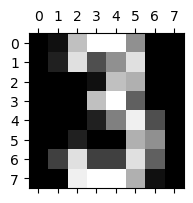

My prediction is 3
sk prediction is 3
Actual number is 3


In [18]:
idx = np.random.randint(X_test.shape[0])
dimage = X_test_org[idx].reshape((8,8))
plt.figure(figsize=(2,2))
plt.gray()
plt.matshow(dimage, fignum=1)
plt.show()

X_input = np.expand_dims(X_test[idx], 0)

y_pred = my_predict(layers, X_input)

s_pred = mlp.predict(X_input)

print('My prediction is ' + str(y_pred[0]))
print('sk prediction is ' + str(s_pred[0]))
print('Actual number is ' + str(y_test[idx]))


(c) 2024 SW Lee